In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint
import scipy.optimize

import sympy as sp

# Import model predictive control stuff

In [2]:
try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.9/162.9 kB 3.9 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/usr/local/lib/python3.12/dist-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


  Cloning https://github.com/vanbreugel-lab/pybounds to /tmp/pip-req-build-s0e4mm0c
  Running command git clone --filter=blob:none --quiet https://github.com/vanbreugel-lab/pybounds /tmp/pip-req-build-s0e4mm0c
  Resolved https://github.com/vanbreugel-lab/pybounds to commit a2a55f7d1bcb0962b780d9973b2bc2ada29589de
  Preparing metadata (setup.py) ... done
  Created wheel for pybounds: filename=pybounds-0.0.13-py3-none-any.whl size=19534 sha256=b3546407626afe893f940e33c6259a82c043750fa5c62b08027043e18d1749d1
  Stored in directory: /tmp/pip-ephem-wheel-cache-85c0ghqp/wheels/cb/f8/fb/ff1887f9a2f35c3edad7b1acb7da69437c1fd8d885a800578d
Successfully built pybounds


### Import plotting utilities and planar drone locally or from github

In [3]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

planar_drone = import_local_or_github('planar_drone', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')

Fetching from: 
<Response [200]>
Fetching from: 
<Response [200]>


# Planar drone dynamics

Now all the drone dynamics are in the helper file, `planar_drone.py`

$
\mathbf{\dot{x}} = \mathbf{f}(\mathbf{x},\mathbf{u}) =
\frac{d}{dt}
\begin{bmatrix}
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{\dot{\theta}} \\[0.3em]
\bbox[yellow]{x} \\[0.3em]
\bbox[yellow]{\dot{x}} \\[0.3em]
\bbox[yellow]{z} \\[0.3em]
\bbox[yellow]{\dot{z}} \\[0.3em]
\bbox[pink]{k}
\end{bmatrix} =
\overset{f_0}{\begin{bmatrix}
\bbox[yellow]{\dot{\theta}} \\[0.3em]
0 \\[0.3em]
\bbox[yellow]{\dot{x}} \\[0.3em]
0 \\[0.3em]
\bbox[yellow]{\dot{z}} \\[0.3em]
-\bbox[lightblue]{g} \\[0.3em]
0
\end{bmatrix}} +
\overset{f_1}{\begin{bmatrix}
0 \\[0.3em]
\bbox[lightblue]{l}\bbox[pink]{k}/\bbox[lightblue]{I_{yy}} \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0
\end{bmatrix}} \bbox[lightgreen]{j_1} +
\overset{f_2}{\begin{bmatrix}
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
-\bbox[pink]{k}\bbox[yellow]{\sin\theta}/\bbox[lightblue]{m} \\[0.3em]
0 \\[0.3em]
\bbox[pink]{k}\bbox[yellow]{\cos\theta}/\bbox[lightblue]{m}  \\[0.3em]
0
\end{bmatrix}} \bbox[lightgreen]{j_2}
$

We begin assuming that we have the following measurements, which could come from a tilt sensor (for theta), gps (for x, z), and a good model of the motors (for k).



$
\mathbf{y} = \mathbf{{h}}(\mathbf{{x}}, \mathbf{{u}}) =
\begin{bmatrix}
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{x} \\[0.3em]
\bbox[yellow]{z} \\[0.3em]
\bbox[pink]{k}
\end{bmatrix}
$

# Dynamics and measurement functions

In [5]:
f = planar_drone.F().f # this funny notation lets us remove k from the state later
h = planar_drone.H('h_gps').h # this funny notation lets us remove k from the state later, and choose different h functions

In [6]:
print('states:')
print(f(None, None, return_state_names=True))
print()
print('measurements:')
print(h(None, None, return_measurement_names=True))

states:
['theta', 'theta_dot', 'x', 'x_dot', 'z', 'z_dot', 'k']

measurements:
['theta', 'x', 'z', 'k']


# Run MPC simulation

In [9]:
t_sim, x_sim, u_sim, y_sim, simulator = planar_drone.simulate_drone(f, h, tsim_length=20, dt=0.1)

### plot the x, z trajectory

Text(0, 0.5, 'z pos')

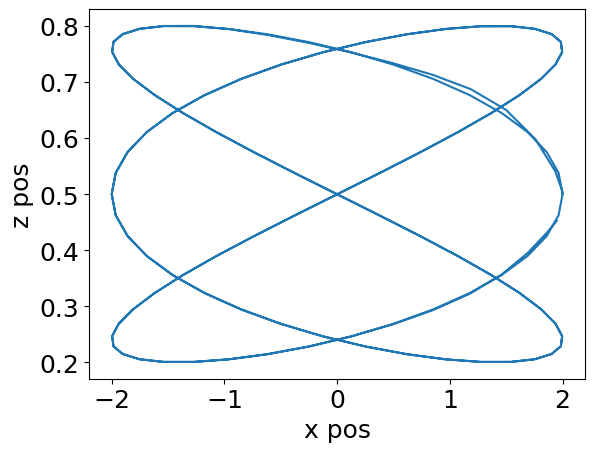

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x_sim['x'], x_sim['z'])

ax.set_xlabel('x pos')
ax.set_ylabel('z pos')

# Simulate noisy measurements

Choose noise properties for each sensor, and apply the noise to each measurement stream

In [11]:
measurement_noise_stds = {'theta': 0.1,
                          'x': 0.2,
                          'z': 0.4,
                          'k': 0.01}

In [12]:
y_noisy = {key: y_sim[key] + np.random.normal(0, measurement_noise_stds[key], len(y_sim[key])) for key in y_sim.keys()}

### Plot some noisy measurements

<Axes: xlabel='Time', ylabel='x'>

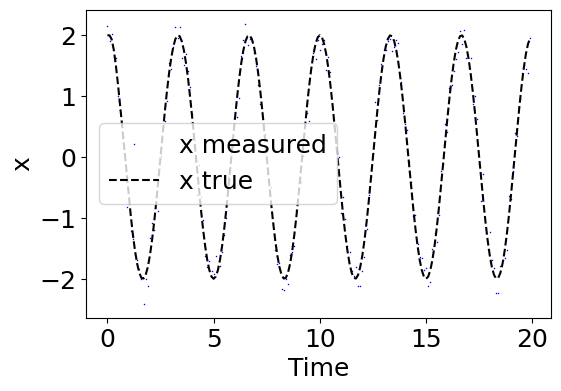

In [13]:
plot_tme(t_sim, y_sim['x'], y_noisy['x'], label_var='x')

# Prepare for a linear discrete time kalman filter

### Linearize the dynamics and measurement function

We need linearized dynamics of the form:

$
\mathbf{x_{k+1}} = A\mathbf{x_k} + B\mathbf{u_k}
$

$
\mathbf{y_k} = C\mathbf{x_k} + D\mathbf{u_k}
$

We will do that numerically using the following helper functions.

### Linearization functions

In [14]:
# Discretize continuous dynamics with the Runge-Kutta 4th order method (RK4)
def rk4_discretize(f, x, u, dt):
    """
    Discretizes the continuous-time dynamics using the Runge-Kutta 4th order method (RK4).

    :param f: Function that defines the system dynamics (dx/dt = f(x, u))
              f should accept the current state `x` and input `u` and return the state derivatives.
    :param x: Current state (numpy array), representing the state at time t
    :param u: Control input (numpy array), control applied at time t
    :param dt: Time step (float), the discretization time step

    :return: Discretized state at time t+dt (numpy array)
    """

    # Step 1: Compute k1, the first estimate of the state change (function evaluation at time t)
    k1 = f(x, u)  # k1 is the rate of change at the current state

    # Step 2: Compute k2, estimate of state change at time t + dt/2, based on k1
    # Perturb x by half the step size (dt/2) in the direction of k1
    k2 = f(x + 0.5 * dt * k1, u)  # k2 is the rate of change at t + dt/2

    # Step 3: Compute k3, another estimate of state change at time t + dt/2, based on k2
    # Perturb x by half the step size (dt/2) in the direction of k2
    k3 = f(x + 0.5 * dt * k2, u)  # k3 is the rate of change at t + dt/2 (but using k2)

    # Step 4: Compute k4, estimate of state change at time t + dt, based on k3
    # Perturb x by the full time step (dt) in the direction of k3
    k4 = f(x + dt * k3, u)  # k4 is the rate of change at t + dt

    # Step 5: Compute the weighted sum of the estimates (k1, k2, k3, k4) to update x
    # The final estimate is a weighted average of all k's
    x_next = x + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

    return x_next

In [15]:
# Linearize with a numerical jacobian
def jacobian_numerical(f, x0, u0, epsilon=0.001):

    # Get A
    Aj = []
    for i in range(len(f(x0,u0))):

        def f_scalar(x,u,i):
            x_new = f(x, u)
            return np.ravel(x_new)[i]

        j = scipy.optimize.approx_fprime(x0, f_scalar, epsilon, u0, i)
        Aj.append(j)

    # Get B
    Bj = []
    for i in range(len(f(x0,u0))):

        def f_scalar(u,x,i):
            x_new = f(x, u)
            return np.ravel(x_new)[i]

        j = scipy.optimize.approx_fprime(u0, f_scalar, epsilon, x0, i)
        Bj.append(j)

    return np.array(np.vstack(Aj)), np.array(np.vstack(Bj))

### Choose an operating point

We can only choose one operating point, typically choose the stable equilibrium where the dynamics will spend most of the time.

In [16]:
# for reference see the states again
print('states:')
print(f(None, None, return_state_names=True))

states:
['theta', 'theta_dot', 'x', 'x_dot', 'z', 'z_dot', 'k']


In [17]:
# initial condition for planar drone in hover mode
x0 = np.array([0, 0, 0, 0, 1, 0, 1])
u0 = np.array([0, 0])

### Discretize and linearize the dynamics

In [18]:
def f_discrete(x, u):
    dt = 0.1
    return rk4_discretize(f, x, u, dt)

In [19]:
A, B = jacobian_numerical(f_discrete, x0, u0, epsilon=1e-6)

print('A:')
sp.pretty_print( np.round(A, 3) )

print('')
print('B:')
sp.pretty_print( np.round(B, 3) )

A:
[[1.  0.1 0.  0.  0.  0.  0. ] 
 [0.  1.  0.  0.  0.  0.  0. ] 
 [0.  0.  1.  0.1 0.  0.  0. ] 
 [0.  0.  0.  1.  0.  0.  0. ] 
 [0.  0.  0.  0.  1.  0.1 0. ] 
 [0.  0.  0.  0.  0.  1.  0. ] 
 [0.  0.  0.  0.  0.  0.  1. ]]

B:
[[0.125 0.   ] 
 [2.5   0.   ] 
 [0.    0.   ] 
 [0.    0.   ] 
 [0.    0.005] 
 [0.    0.1  ] 
 [0.    0.   ]]


### Linearize the measurements

Note: the measurements function is not specified as continuous or discrete, it does not need to be discretized.

In [20]:
C, D = jacobian_numerical(h, x0, u0, epsilon=1e-6)

print('C:')
sp.pretty_print( np.round(C, 3) )

print('')
print('D:')
sp.pretty_print( np.round(D, 3) )

C:
[[1. 0. 0. 0. 0. 0. 0.] 
 [0. 0. 1. 0. 0. 0. 0.] 
 [0. 0. 0. 0. 1. 0. 0.] 
 [0. 0. 0. 0. 0. 0. 1.]]

D:
[[0. 0.] 
 [0. 0.] 
 [0. 0.] 
 [0. 0.]]


### Define the measurement covariance matrix R

$R =
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}
\begin{bmatrix}
\sigma_\theta^2 \\
\sigma_x^2 \\
\sigma_z^2 \\
\sigma_k^2
\end{bmatrix} =
\begin{bmatrix}
\sigma_\theta^2 & 0 & 0 & 0 \\
0 & \sigma_x^2 & 0 & 0 \\
0 & 0 & \sigma_z^2 & 0 \\
0 & 0 & 0 & \sigma_k^2 \\
\end{bmatrix}
$

In [21]:
R = np.diag( list(measurement_noise_stds.values()) )**2

print('R:')
sp.pretty_print( np.round(R, 4) )

R:
[[1.0e-02 0.0e+00 0.0e+00 0.0e+00] 
 [0.0e+00 4.0e-02 0.0e+00 0.0e+00] 
 [0.0e+00 0.0e+00 1.6e-01 0.0e+00] 
 [0.0e+00 0.0e+00 0.0e+00 1.0e-04]]


# Define the process covariance matrix Q

The diagonal of Q corresponds to the variance of the model for each state. In this case, we can set it to a small value, but equal across states.

In [22]:
Q = np.diag([1e-4]*4)

print('R:')
sp.pretty_print( np.round(Q, 4) )

R:
[[0.0001 0.     0.     0.    ] 
 [0.     0.0001 0.     0.    ] 
 [0.     0.     0.0001 0.    ] 
 [0.     0.     0.     0.0001]]


# Exercises:

Save the following to disk:
  * $A, B, C, D, R, Q$ matrices defined above
  * t_sim, x_sim, y_sim, u_sim

Hint 1: Lesson 1 showed you how to save `t_sim, x_sim, y_sim, u_sim` to disk.

Hint 2: For `A, B, C, D, R, Q`, consider using `pickle` (or `dill`). Ask AI for help.